##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to TensorFlow Part 2 - Debugging and Control Flow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Introduction_to_TensorFlow_Part_2_-_Debugging_and_Control_Flow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Introduction_to_TensorFlow_Part_2_-_Debugging_and_Control_Flow.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Upgrade to TensorFlow 2.1+
!pip install --upgrade tensorflow

In [15]:
#@title Install and import Libraries for this colab. RUN ME FIRST!
!pip install matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.summary.writer.writer import FileWriter
%load_ext tensorboard

# Use graph mode for this training
#tf.compat.v1.disable_eager_execution()



# What this notebook covers

This notebook carries on from [part 1](https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Introduction_to_TensorFlow_Part_1_-_Basics.ipynb), and covers the basics of control flow and debugging in tensorflow: 
*   various debugging aids
*   loops
*   conditionals

These features are used in graph mode of inside a `tf.function`. For simplicity eager execution is disabled throughout the training.



# Debugging

## tf.py_function

[Full documentation](https://www.tensorflow.org/api_docs/python/tf/py_function)

This allows you to wrap a python function as an op. The function can make further calls into tensorflow, allowing e.g. a subset of tensorflow operations to be wrapped up inside the function and inspected using pdb. 

There are various restrictions involved with this op and 
*   serializing execution graphs
*   executing across distributed machines

Read the documentation for more information. As such, this should be viewed as more of a debugging tool, and its use should be avoided in performance-sensitive code.





In [ ]:
def plus_one(x):
  print("input has type %s, value %s"%(type(x), x))
  output = x + 1.0
  print("output has type %s, value %s"%(type(output), output))
  return output

x = tf.constant([1.0,2.0,3.0])

a = tf.py_function(plus_one, inp = [x], Tout=tf.float32)

with tf.compat.v1.Session() as sess:
  print(sess.run(a))

## tf.print

[Full Documentation](https://www.tensorflow.org/api_docs/python/tf/print)

The `tf.print` op is another useful debugging tool. It takes any number of tensors and python objects, and prints them to stdout. There are a few optional parameters, to control formatting and where it prints to. See the documentation for details.

In [ ]:
a = tf.constant(1)
print_trace = tf.print(
    "a has value", a, ", type", type(a), "and shape", tf.shape(a))

with tf.compat.v1.Session() as sess:
  results = sess.run(print_trace)

If you're using eager execution mode, that's all you need to know. For deferred execution however there are some significant complications that we'll discuss in the next section.

Note that there's a similar op [tf.Print](https://www.tensorflow.org/api_docs/python/tf/Print) (note the capital P), that doesn't suffer from these complications, but the op is deprecated and due to disappear.

## tf.control_dependencies
[Full Documentation](https://www.tensorflow.org/api_docs/python/tf/control_dependencies)

One of the easiest optimisations tensorflow makes when in deferred mode is to eliminate unused ops. So if we run this:

In [9]:
a = tf.constant(1) + tf.constant(1)
print_trace = tf.print("a is set to ", a)
b = a*2

with tf.compat.v1.Session() as sess:
  results = sess.run(b)

Then we don't get any output. Nothing depends on ```print_trace``` (in fact nothing *can* depend on it: tf.print doesn't return anything to depend on), so it gets dropped from the graph before execution occurs. If you want ```print_trace``` to be evaluated, then you need to ask for it explicitly:


In [10]:
a = tf.constant(1) + tf.constant(1)
print_trace = tf.compat.v1.print("a is set to", a)
b = a*2

with tf.compat.v1.Session() as sess:
  results = sess.run((b,print_trace))

a is set to 2


That's fine for our noddy sample above. But obviously has problems as your graph grows larger or the `sess.run` method gets further removed from the graph definition. The solution for that is ```tf.control_dependencies```. This signals to tensorflow that the given set of prerequisite ops must be evaluated before a set of dependent ops. 


In [12]:
a = tf.constant(1) + tf.constant(1)
print_trace = tf.print("a is set to", a)
hello_world = tf.print("hello world")

with tf.control_dependencies((print_trace, hello_world)):
  # print_trace and hello_world will always be evaluated 
  # before b can be evaluated
  b = a*2
c = a*3

with tf.compat.v1.Session() as sess:
  results = sess.run(b)

hello world
a is set to 2


Note that if all of the dependent ops are pruned from the dependency tree and thus not evaluated, then the prerequisites will not be evaluated either: e.g. if we call ```sess.run(c)``` in the example above,then `print_trace` and `hello_world` won't be evaluated




In [13]:
# Nothing gets printed
with tf.compat.v1.Session() as sess:
  results = sess.run(c)

## tf.debugging.Assert
[Full Documentation](https://www.tensorflow.org/api_docs/python/tf/debugging/Assert)

In addition to ```tf.print```, the other common use of control_dependencies is ```tf.debugging.Assert```. This op does what you'd expect: checks a boolean condition and aborts execution with a InvalidArgumentError if the condition is not true. Just like ```tf.print```, it is likely to be pruned from the dependency tree and ignored if run in deferred execution mode without control_dependencies

In [4]:
x = tf.compat.v1.placeholder(tf.float32, shape=[])

with tf.control_dependencies([
    tf.debugging.Assert(tf.not_equal(x, 0), ["Invalid value for x:",x])]):
  y = 2.0 / x


with tf.compat.v1.Session() as sess:
  try:
    results = sess.run(y, feed_dict={x: 0.0})
  except tf.errors.InvalidArgumentError:
    print('Value of x is zero')

Value of x is zero


There are also a bunch of helper methods, such as 
*   [assert_equal](https://www.tensorflow.org/api_docs/python/tf/debugging/assert_equal)
*   [assert_positive](https://www.tensorflow.org/api_docs/python/tf/debugging/assert_positive)
*   [assert_rank_at_least](https://www.tensorflow.org/api_docs/python/tf/debugging/assert_rank_at_least)
*   etc.

to simplify common uses of ```tf.Assert```

So our sample above could have been written as

In [3]:
x = tf.compat.v1.placeholder(tf.float32, shape=[])

with tf.control_dependencies([tf.debugging.assert_none_equal(x, 0.0)]):
  y = 2.0 / x

with tf.compat.v1.Session() as sess:
  try:
    results = sess.run(y, feed_dict={x: 0.0})
  except tf.errors.InvalidArgumentError:
    print('Value of x is zero')

Value of x is zero


# Control Flow

## tf.cond
[Full Documentation](https://www.tensorflow.org/api_docs/python/tf/cond)

The cond operand is the TensorFlow equivalent of if-else. It takes 
*   a condition, which must resolve down to a single scalar boolean
*   true_fn: a python callable to generate one or more tensors that will be evaluated if the condition is true
*   false_fn: same as true_fn, but the resulting tensors will only be evaluated if the the condition is false

The condition is evaluated, and if its result is true then, the tensors generated by true_fn are evaluated and those generated by false_fn are abandoned (and vice versa if the result is false). 

Note that true_fn and false_fn must be python functions (or lambdas), not just tensors:

In [6]:
# This won't work
try:
  tf.cond(tf.constant(True), tf.constant(1), tf.constant(2))
except TypeError:
  pass
# You need a callable:
tf.cond(tf.constant(True), lambda: tf.constant(1), lambda: tf.constant(2))

<tf.Tensor 'cond_1/Identity:0' shape=() dtype=int32>

The exact order of execution is a little complicated
*   true_fn and false_fn are executed just once, when the graph is being built. 
*   the tensors created by true_fn (if the condition is true) or false_fn (if the condition is false) will be evaluated stricly after the condition has been evaluated
*   the tensors created by false_fn (if the condition is true) or true_fn (if the condition is false) will never be evaluated
*   any tensors depended on by the tensors generated by true_fn or false_fn will be always evaluated, even regardless of what the condition evaluates to

In [7]:
def dependency_fn():
  print ("DEPENDENCY: I'm always evaluated at execution time because I'm a dependency\n")
  return tf.constant(2)
dependency = tf.py_function(dependency_fn, inp=[], Tout=tf.int32)

def true_op_fn():
  print ("TRUE_OP_FN: I'm evaluated at execution time because condition is True\n")
  return 1

def true_fn():
  print ("TRUE_FN: I'm evaluated at graph building time")
  return tf.py_function(true_op_fn, inp=[], Tout=tf.int32)

def false_op_fn(input):
  print ("FALSE_OP_FN: I'm never evaluated because condition isn't False\n")
  return 1 + input

def false_fn():
  print ("FALSE_FN: I'm evaluated at graph building time")
  return tf.py_function(false_op_fn, inp=[dependency], Tout=tf.int32)


print("****** Building graph")

def predicate_fn():
  print("PREDICATE: I'm evaluated at execution time\n")
  return tf.constant(True)
x = tf.cond(tf.py_function(predicate_fn, inp=[], Tout=tf.bool), true_fn, false_fn)

print("****** Executing graph")
with tf.compat.v1.Session() as sess:
  sess.run(x)

****** Building graph
TRUE_FN: I'm evaluated at graph building time
FALSE_FN: I'm evaluated at graph building time
****** Executing graph
PREDICATE: I'm evaluated at execution time

DEPENDENCY: I'm always evaluated at execution time because I'm a dependency

TRUE_OP_FN: I'm evaluated at execution time because condition is True



## tf.while_loop
[Full Documentation](https://www.tensorflow.org/api_docs/python/tf/while_loop)

This is one of the more complicated ops in TensorFlow, so we'll take things step by step. 

*   The most important parameter is ```loop_vars```. This is a tuple/list of tensors.

*   Next up is ```cond``` this is a python callable that should take the same number of arguments as loop_vars contains, and returns a single boolean.

*   The third important parameter is ```body```. This is a python callable that should take the same number of arguments as loop_vars contains, and returns a tuple/list of values with the same size as loop_vars, and whose members are of the same type/arity/shape as those in loop_vars.

Note that like the ```trun_fn``` and ```false_fn``` parameters discussed in tf.cond above, ```body``` and ```cond``` are callables, that are called once during graph definition.

To a first level approximation, the behaviour is then roughtly akin to the following pseudo-code:
```python
working_vars = loop_vars
while(cond(*working_vars)):
  working_vars = body(*working_vars)
return working_vars
```


There are optional complications:
*   By default, each loop variable must have exactly the same shape/size/arity in all iterations. If you don't want that (e.g. because you want to increase the size in a particular dimnension by 1 each iteration), then you can use ```shape_invariants``` to loosen the checks.
*   ```maximum_iterations``` can be used to put an upper bound on number of times the loop is executed, even if cond still returns true

The documentation contains some warnings about parallel executions, race conditions and variables getting out of sync. To understand these, we need to beyond the first level approximation above. Consider the following:
```python
index = tf.constant(1)
accumulator = tf.constant(0)

loop = tf.while_loop(
    loop_vars=[index, accumulator], 
    cond = lambda idx, acc: idx < 4, 
    body = lambda idx, acc: [idx+1, acc + idx] )
```

To a second level approximation, this is equivalent to

```python
index_initial = tf.constant(1)
accumalator_initial = tf.constant(0)

index_iteration_1 = tf.add(index_initial, 1)
index_iteration_2 = tf.add(index_iteration_1, 1)
index_iteration_3 = tf.add(index_iteration_2, 1)

accumulator_iteration_1 = tf.add(
  accumalator_initial, index_initial)
accumulator_iteration_2 = tf.add(
  accumulator_iteration_1, index_iteration_1)
accumulator_iteration_3 = tf.add(
  accumulator_iteration_2, index_iteration_2)

loop = [index_iteration_3, accumulator_iteration_3]
```
(for the full, unapproximated, gory details of the graph, run the code below

In [ ]:
tf.compat.v1.reset_default_graph()

index = tf.constant(1)
accumulator = tf.constant(0)

loop = tf.while_loop(
    loop_vars=[index, accumulator], 
    cond = lambda idx, acc: idx < 4, 
    body = lambda idx, acc: [idx+1, acc + idx] )

with tf.compat.v1.Session() as sess:
  with FileWriter("logs", sess.graph):
    results = sess.run(loop)
  
%tensorboard --logdir logs

but our second-level approximation will do for now).

Notice how index_iteration_3 doesn't depend the accumulator values at all. Thus assuming our accumulator tensors were doing something more complicated than adding two integers, and assuming we were running on hardware with plenty of execution units, then it's possible that index_iteration_3 could be fully calculated in one thead, while accumulator_iteration_1 is still being calculated in another.

It usually doesn't matter, because loop depends on both index_iteration_3 and accuulator_iteration_3, so it and any dependencies can't start their evaluation before all the accumulation steps have completed. But if you're depending on side effects, or clever operations depending on global state that tensorflow is unware of (e.g. in custom kernels, or py_function ops), then it's something to be aware of. You can use the while_loop's parallel_iterations parameter to restrict the number of iterations that can be calulated in parallel if this does become an issue.

## Exercise: Mandlebrot set

Recall that the Mandelbrot set is defined as the set of values of $c$ in the complex plane such that the recursion:  
$z_{n+1} = z_{n}^2 + c$ does not diverge.

It is known that all such values of $c$ lie inside the circle of radius $2$ around the origin.

So what we'll do is


*   Create a 2-d tensor ```c_values``` ranging from -1-1i to 1+1i
*   Create a matching 2-d tensor ```Z_values``` with initial values of 0
*   Create a third 2-d tensor ```diverged_after``` which contains the iteration number that the matching Z_value's absolute value was > 2 (or MAX_ITERATIONS, if it always stayed below 2)
*   Update the above using a while_loop
*   display the final values of ```diverged_after``` as an image to see the famous shape





In [17]:
MAX_ITERATIONS = 64
NUM_PIXELS = 512

def GenerateGrid(nX, nY, bottom_left=(-1.0, -1.0), top_right=(1.0, 1.0)):
  """Generates a complex matrix of shape [nX, nY].
  
  Generates an evenly spaced grid of complex numbers spanning the rectangle 
  between the supplied diagonal points. 
  
  Args:
    nX: A positive integer. The number of points in the horizontal direction.
    nY: A positive integer. The number of points in the vertical direction.
    bottom_left: The coordinates of the bottom left corner of the rectangle to
      cover.
    top_right: The coordinates of the top right corner of the rectangle to
      cover.

  Returns:
    A constant tensor of type complex64 and shape [nX, nY].
  """
  x = tf.linspace(bottom_left[0], top_right[0], nX)
  y = tf.linspace(bottom_left[1], top_right[1], nY)
  real, imag = tf.meshgrid(x, y)
  return tf.cast(tf.complex(real, imag), tf.complex128)

c_values = GenerateGrid(NUM_PIXELS, NUM_PIXELS)
initial_Z_values = tf.zeros_like(c_values, dtype=tf.complex128)
initial_diverged_after = tf.ones_like(c_values, dtype=tf.int32) * MAX_ITERATIONS

# You need to put the various values you want to change inside the loop here
loop_vars = ()

# this needs to take the same number of arguments as loop_vars contains and
# return a tuple of equal size with the next iteration's values
def body():
  # hint: tf.abs will give the magnitude of a complex value
  return ()

# this just needs to take the same number of arguments as loop_vars contains and
# return true (we'll use maximum_iterations to exit the loop)
def cond():
  return True

loop = tf.while_loop(
    loop_vars=loop_vars, 
    body = body, 
    cond = cond, 
    maximum_iterations=MAX_ITERATIONS)

with tf.compat.v1.Session() as sess:
  results = sess.run(loop)

## extract the final value of diverged_after from the tuple
final_diverged_after = results[-1]
plt.matshow(final_diverged_after)
pass



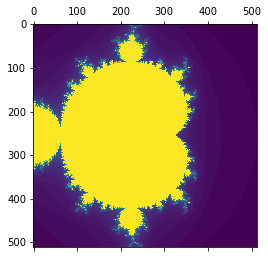

In [20]:
#@title Solution: Mandlebrot set (Double-click to reveal)

MAX_ITERATIONS = 64
NUM_PIXELS = 512

def GenerateGrid(nX, nY, bottom_left=(-1.0, -1.0), top_right=(1.0, 1.0)):
  """Generates a complex matrix of shape [nX, nY].
  
  Generates an evenly spaced grid of complex numbers spanning the rectangle 
  between the supplied diagonal points. 
  
  Args:
    nX: A positive integer. The number of points in the horizontal direction.
    nY: A positive integer. The number of points in the vertical direction.
    bottom_left: The coordinates of the bottom left corner of the rectangle to
      cover.
    top_right: The coordinates of the top right corner of the rectangle to
      cover.

  Returns:
    A constant tensor of type complex64 and shape [nX, nY].
  """
  x = tf.linspace(bottom_left[0], top_right[0], nX)
  y = tf.linspace(bottom_left[1], top_right[1], nY)
  real, imag = tf.meshgrid(x, y)
  return tf.cast(tf.complex(real, imag), tf.complex128)

c_values = GenerateGrid(NUM_PIXELS, NUM_PIXELS)
initial_Z_values = tf.zeros_like(c_values, dtype=tf.complex128)
initial_diverged_after = tf.ones_like(c_values, dtype=tf.int32) * MAX_ITERATIONS

# You need to put the various values you want to change inside the loop here
loop_vars = (0, initial_Z_values, initial_diverged_after)

# this needs to take the same number of arguments as loop_vars contains and
# return a tuple of equal size with the next iteration's values
def body(iteration_count, Z_values, diverged_after):
  new_Z_values = Z_values * Z_values + c_values
  has_diverged = tf.abs(new_Z_values) > 2.0
  new_diverged_after = tf.minimum(diverged_after, tf.where(
      has_diverged, iteration_count, MAX_ITERATIONS))
  return (iteration_count+1, new_Z_values, new_diverged_after)

# this just needs to take the same number of arguments as loop_vars contains and
# return true (we'll use maximum_iterations to exit the loop)
def cond(iteration_count, Z_values, diverged_after):
  return True

loop = tf.while_loop(
    loop_vars=loop_vars, 
    body = body, 
    cond = cond, 
    maximum_iterations=MAX_ITERATIONS)

with tf.compat.v1.Session() as sess:
  results = sess.run(loop)

## extract the final value of diverged_after from the tuple
final_diverged_after = results[-1]
plt.matshow(final_diverged_after)
plt.show()